In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 882.2 kB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil
import os
import skimage.io as sk

2024-05-08 11:05:31.323397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:05:31.323497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:05:31.435779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:

timm.list_models("")

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [6]:
model_name = "timm/vit_base_patch8_224.in1k"

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
from tqdm import tqdm

# Settings
num_epochs = 4
num_accumulate = 4

# Criterion and Metric
criterion = nn.CrossEntropyLoss()
metric = evaluate.load("f1")

In [8]:
train_path = '/kaggle/input/ml-dataset/dataset/training'
val_path = '/kaggle/input/ml-dataset/dataset/validation'

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T

train_batch_size = 16
eval_batch_size = 16

# ปรับ pipeline ให้เหมาะสมกับ ViT
data_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=TF.InterpolationMode.BICUBIC),  # ปรับขนาดรูปภาพเป็น 224x224
    transforms.ToTensor(),  # แปลงรูปเป็น Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ทำ normalization โดยใช้ mean=[0.5, 0.5, 0.5] และ std=[0.5, 0.5, 0.5]
])

train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=data_transforms
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root=val_path,
    transform=data_transforms
)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)


### EDA

In [10]:
!pip install stegano

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 1.1 MB/s eta 0:00:00


In [11]:
!pip install jpegio
import jpegio as jio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.5 MB/s eta 0:00:00


In [12]:
BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
train_imageids = pd.Series(os.listdir(BASE_PATH + '/cover')).sort_values(ascending=True).reset_index(drop=True)

In [13]:
BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
cover_images_path = pd.Series(BASE_PATH + '/cover/' + train_imageids ).sort_values(ascending=True)
JMIPOD_images_path = pd.Series(BASE_PATH + '/jmipod/'+train_imageids).sort_values(ascending=True)
JUNIWARD_images_path = pd.Series(BASE_PATH + '/juniward/'+train_imageids).sort_values(ascending=True)
UERD_images_path = pd.Series(BASE_PATH + '/uerd/'+train_imageids).sort_values(ascending=True)

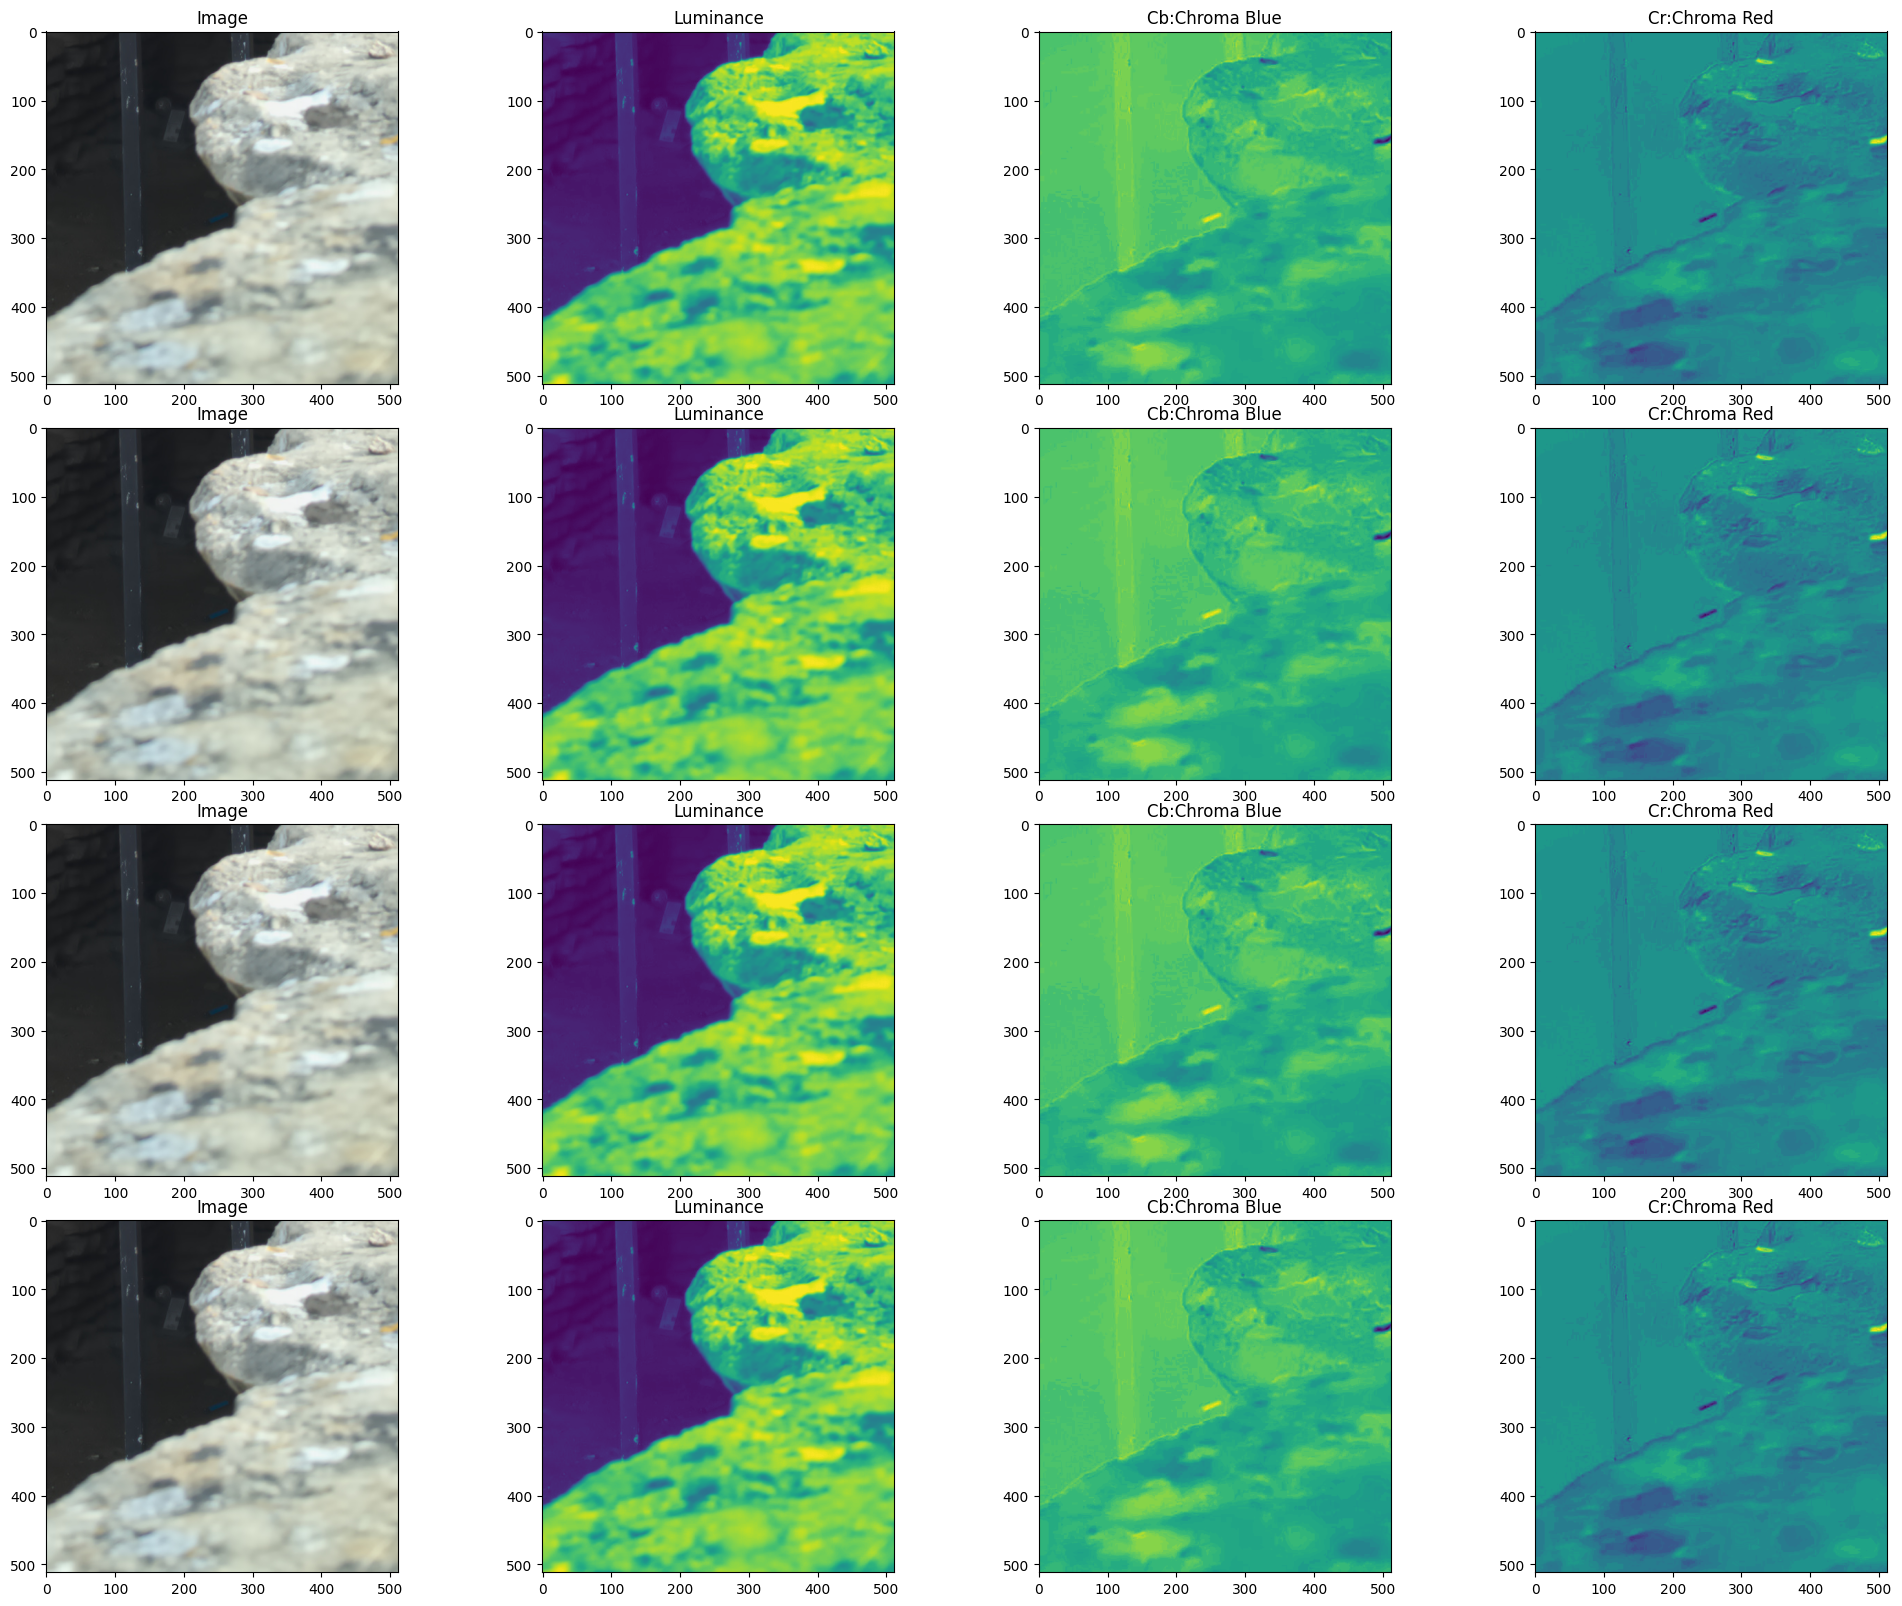

In [14]:
fig,ax = plt.subplots(4,4,figsize=(20,16))
plt.tight_layout()


im1 = Image.open(cover_images_path[0])
im2 = Image.open(JUNIWARD_images_path[0])
im3 = Image.open(JMIPOD_images_path[0])
im4 = Image.open(UERD_images_path[0])

for i,image in enumerate([im1,im2,im3,im4]):
    ycbcr = image.convert('YCbCr')
    (y, cb, cr) = ycbcr.split()

    ax[i,0].imshow(image)
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y)
    ax[i,1].set_title('Luminance')
    ax[i,2].imshow(cb)
    ax[i,2].set_title('Cb:Chroma Blue')
    ax[i,3].imshow(cr)
    ax[i,3].set_title('Cr:Chroma Red')

In [15]:
coverDCT = np.zeros([512,512,3])
stegoDCT = np.zeros([512,512,3])
jpeg = jio.read(cover_images_path[0])
stego_juni = jio.read(JUNIWARD_images_path[0])

328
[-1.  0.  1.]


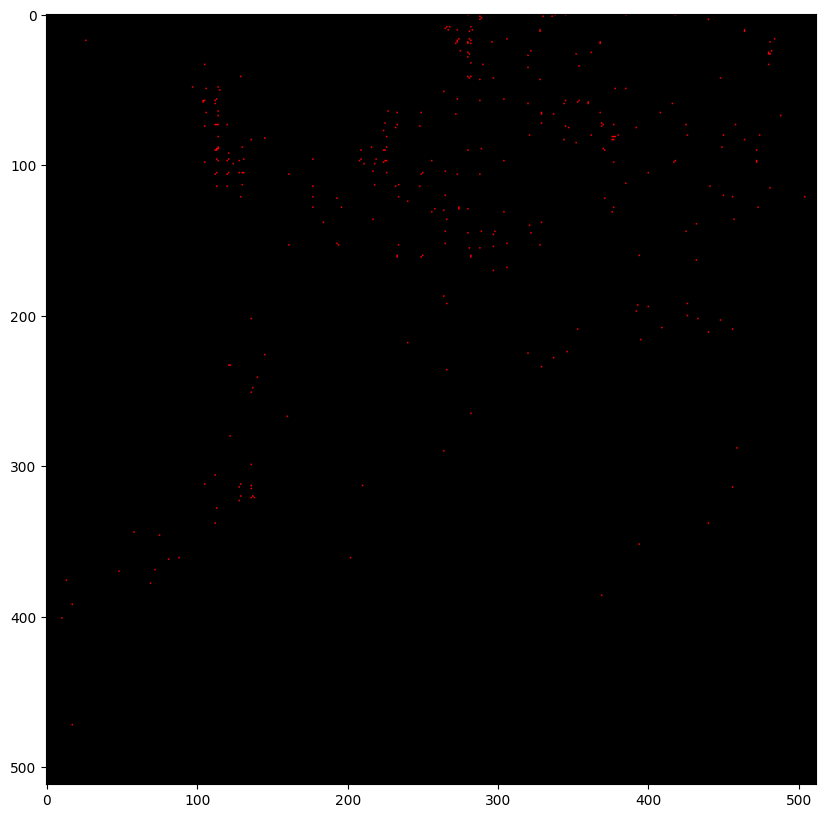

In [16]:
coverDCT[:,:,0] = jpeg.coef_arrays[0] ; coverDCT[:,:,1] = jpeg.coef_arrays[1] ; coverDCT[:,:,2] = jpeg.coef_arrays[2]
stegoDCT[:,:,0] = stego_juni.coef_arrays[0] ; stegoDCT[:,:,1] = stego_juni.coef_arrays[1] ; stegoDCT[:,:,2] = stego_juni.coef_arrays[2]

DCT_diff = coverDCT - stegoDCT
# So since they are not the same Images the DCT_diff would not be zero
print(len(DCT_diff[np.where(DCT_diff!=0)]))
print(np.unique(DCT_diff))
plt.figure(figsize=(16,10))
plt.imshow( abs(DCT_diff) )
plt.show()

6678
[-2. -1.  0.  1.  2.]


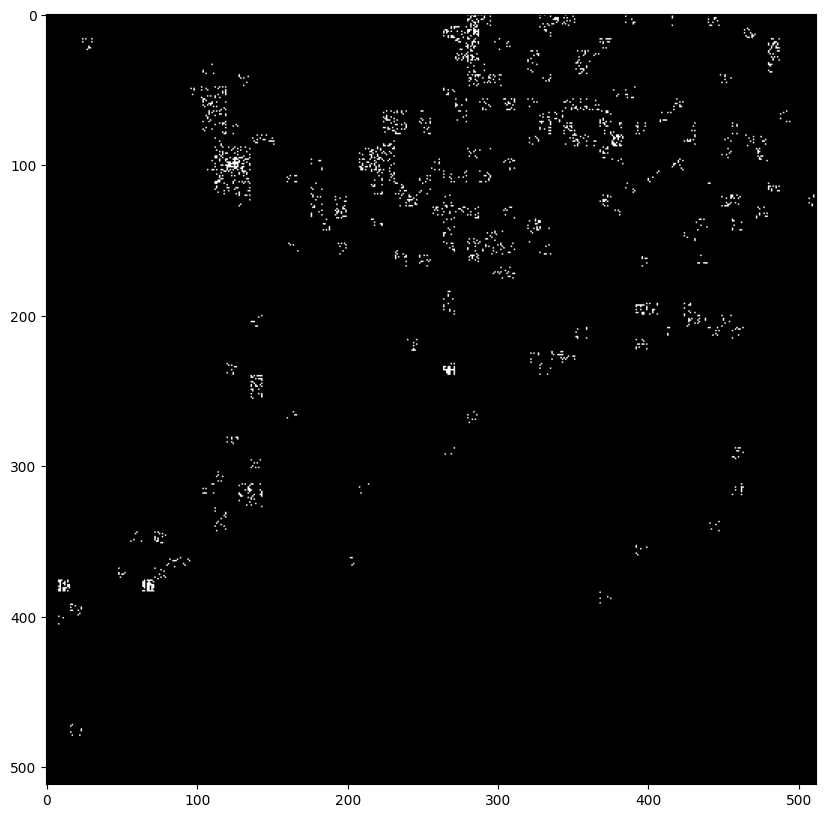

In [17]:
coverPixels = np.array(Image.open(cover_images_path[0])).astype('float')
stegoPixels = np.array(Image.open(JUNIWARD_images_path[0])).astype('float')

pixelsDiff = coverPixels - stegoPixels

# So since they are not the same Images the pixels_diff would not be zero
print(len(pixelsDiff[np.where(pixelsDiff!=0)]))
print(np.unique(pixelsDiff))
plt.figure(figsize=(16,10))
plt.imshow( abs(pixelsDiff) )
plt.show()

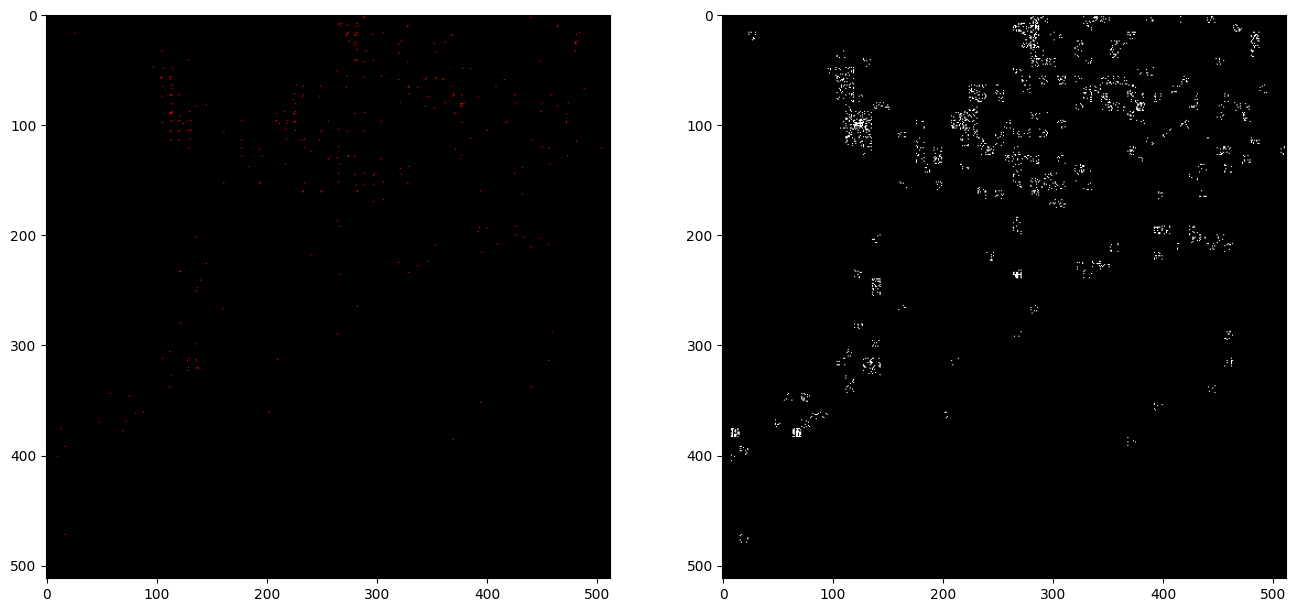

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,12))
ax[0].imshow(abs(DCT_diff))
ax[1].imshow(abs(pixelsDiff))

In [19]:
# Check the first few batches
for inputs, targets in train_dataloader:
    print("Sample inputs size:", inputs.size())
    print("Sample targets:", targets)
    break

Sample inputs size: torch.Size([16, 3, 224, 224])
Sample targets: tensor([0, 0, 2, 2, 2, 2, 3, 0, 2, 2, 2, 3, 2, 2, 3, 2])


0


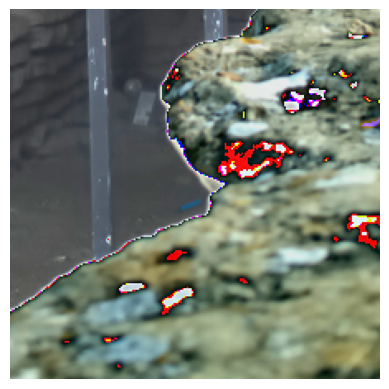

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    to_image = T.ToPILImage()
    img = to_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img_tensor, label = train_dataset[0]
print(label)
show_image(img_tensor)

In [21]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import timm
from timm.data import Mixup
from timm.loss import LabelSmoothingCrossEntropy
from timm.optim import Lookahead
from timm.scheduler import CosineLRScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Optimizer, and Scheduler
model = timm.create_model("vit_base_patch8_224", pretrained=True, num_classes=4)  # ใช้โมเดล ViT ที่เหมาะสำหรับรูปภาพขนาด 224x224

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

criterion = LabelSmoothingCrossEntropy(smoothing=0.1).to(device)  # เลือก loss function ที่เหมาะสำหรับการทำนายแบบหลายคลาส

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # เลือก optimizer และ learning rate เหมาะสำหรับโมเดล ViT

scheduler = CosineLRScheduler(optimizer, t_initial=10, cycle_mul=1.0, lr_min=1e-5, warmup_lr_init=1e-6, warmup_t=0)  # เลือก scheduler ที่เหมาะสำหรับโมเดล ViT

best_metric_val = -999
for epoch in range(num_epochs):
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    train_preds = []
    train_targets = []
    
    val_preds = []
    val_targets = []
    
    num_updates = epoch * len(train_dataloader)

    # Training Loop
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch.append(loss.item())
        train_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
        train_targets.extend(targets.tolist())
        
    scheduler.step(epoch + 1)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss_epoch.append(loss.item())
            val_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
            val_targets.extend(targets.tolist())

    # Calculate Metrics
    metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
    metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]

    # Best Model Check
    if metric_val > best_metric_val:
        best_metric_val = metric_val
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_vit_base_patch8_224_epoch_{epoch}.pt")

    print(f"Epoch {epoch}: Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(val_loss_epoch)}, Train F1 {metric_train}, Val F1 {metric_val}")


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using 2 GPUs!


100%|██████████| 500/500 [05:22<00:00,  1.55it/s]


Epoch 0: Train Loss 1.398468028817858, Val Loss 1.3875461812019347, Train F1 0.24817253493925878, Val F1 0.1


100%|██████████| 500/500 [04:43<00:00,  1.77it/s]


Epoch 1: Train Loss 1.3905198497772218, Val Loss 1.3910614612102508, Train F1 0.24613131582434078, Val F1 0.1


100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


Epoch 2: Train Loss 1.388272672516959, Val Loss 1.386457878112793, Train F1 0.24738193238274706, Val F1 0.11022615479157151


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Epoch 3: Train Loss 1.3870612349510192, Val Loss 1.3865512912273408, Train F1 0.2478256742717618, Val F1 0.1


In [22]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Path to the validation dataset and model
test_path = '/kaggle/input/ml-dataset/dataset/validation'
model_path = "/kaggle/input/maxvit_10_6_epoch/pytorch/best_model_eva02_base_patch14_448_6_epoch/1/best_model_eva02_base_patch14_448_6_epoch.pt"

# Device configuration (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations used for the validation data
data_transforms = transforms.Compose([
    transforms.Resize((448, 448), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

# Load the dataset using the specified transformations
test_dataset = datasets.ImageFolder(
    root=test_path,
    transform=data_transforms
)

# Create a data loader for the validation dataset
test_batch_size = 16
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Load the trained model
loaded_model = torch.load(model_path)
loaded_model.to(device)
loaded_model.eval()

# Initialize lists for predictions and references (actual labels)
predictions = []
references = []

# Disable gradient calculation for prediction
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # Get inputs and targets from the batch
        inputs, targets = batch
        inputs = inputs.to(device)
        
        # Run the inputs through the model to get predictions
        outputs = loaded_model(inputs)
        
        # Determine the predicted class for each sample
        preds = outputs.argmax(dim=-1)
        
        # Append predictions and actual labels to the respective lists
        predictions.extend(preds.cpu().tolist())
        references.extend(targets.tolist())

# Compute the confusion matrix using the actual and predicted labels
cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot and display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate a classification report for accuracy, precision, recall, and F1 score
report = classification_report(references, predictions, target_names=test_dataset.classes)
print(report)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/maxvit_10_6_epoch/pytorch/best_model_eva02_base_patch14_448_6_epoch/1/best_model_eva02_base_patch14_448_6_epoch.pt'

In [ ]:
from torchvision import datasets, transforms

test_files = glob.glob("/kaggle/input/alaska2-image-steganalysis/Test/*.jpg")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataloader = ImageDataset("/kaggle/input/alaska2-image-steganalysis/Test", transform=data_transforms)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
answers_final = dict()

loaded_model = torch.load(f"/kaggle/input/maxvit_10_6_epoch/pytorch/maxvit_10_6_epoch/1/best_model.pt")

model = loaded_model

model.eval()

with torch.no_grad():
    for f in tqdm(test_files):
        key = f.split("/")[-1].split(".")[0]
        img = Image.open(f).convert("RGB")
        
        transformed = data_transforms(img).unsqueeze(0).to(device)
        y_pred = model(transformed)
        y_pred = 1 - torch.nn.functional.softmax(y_pred, dim=1).cpu().numpy()[:, 0]

        answers_final[key] = y_pred.tolist() 

In [ ]:
answers_final

In [ ]:
submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')

In [ ]:
for file_id, label in answers_final.items():
    file_name = f'{file_id}.jpg'
    if file_name in submission['Id'].values:
        submission.loc[submission['Id'] == file_name, 'Label'] = label[0]

# Save the updated submission file
submission.to_csv('updated_submission.csv', index=False)

print("Updated submission file is saved as 'updated_submission.csv'.")